In [2]:
import numpy as np

In [3]:
X = np.load('X_grassman_alanine.npy')

In [4]:
X = [x for x in X]

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from msmbuilder.decomposition import tICA
tica = tICA(n_components=20,lag_time=10)

In [5]:
tica.fit(X[:-1])
tica.score_,tica.score([X[-1]])

(13.112631944746653, 12.601816593092794)

In [11]:
def loo_cv(model,X):
    train,test = [],[]
    
    for i in range(len(X)):
        model.fit(X[:i]+X[i+1:])
        train.append(model.score_)
        test.append(model.score([X[i]]))
    return train,test

In [20]:
train,test = loo_cv(tica,X)

In [21]:
np.mean(train),np.std(train),np.mean(test),np.std(test)

(13.125738420516843,
 0.011711696651828118,
 12.410259149099717,
 0.15702689307878831)

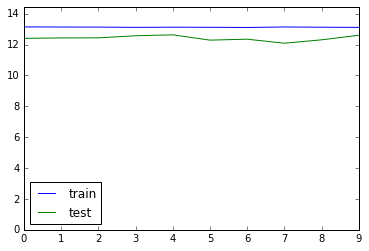

In [26]:
plt.plot(train,label='train')
plt.plot(test,label='test')

plt.ylim(0,np.max(train+test)*1.1)
plt.legend(loc='best')

In [6]:
import pyemma
tica = pyemma.coordinates.tica(X)
X_tica = tica.get_output()

getting output of TICA: 100% (20/20) [#############################] eta 00:00 |

In [37]:
kmeans = pyemma.coordinates.cluster_mini_batch_kmeans(X_tica,k=100,max_iter=1000)
dtrajs = [dtraj.flatten() for dtraj in kmeans.get_output()]

kmeans iterations:   6% (  64/1000) [#                             ] eta 01:39 /07-05-16 22:48:48 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[9] INFO     Cluster centers converged after 65 steps.
getting output of MiniBatchKmeansClustering: 100% (20/20) [########] eta 00:01 |

In [38]:
from msmbuilder.msm import MarkovStateModel
msm = MarkovStateModel(lag_time=20,n_timescales=100)
msm.fit(dtrajs[:-1])
msm.score_,msm.score([dtrajs[-1]])

MSM contains 1 strongly connected component above weight=0.05. Component 0 selected, with population 100.000000%
MSM contains 1 strongly connected component above weight=0.05. Component 0 selected, with population 100.000000%


(26.075332567581022, 21.359346809402194)

In [39]:
train,test = loo_cv(msm,dtrajs)

MSM contains 1 strongly connected component above weight=0.05. Component 0 selected, with population 100.000000%
MSM contains 1 strongly connected component above weight=0.05. Component 0 selected, with population 100.000000%
MSM contains 1 strongly connected component above weight=0.05. Component 0 selected, with population 100.000000%
MSM contains 1 strongly connected component above weight=0.05. Component 0 selected, with population 100.000000%
MSM contains 1 strongly connected component above weight=0.05. Component 0 selected, with population 100.000000%
MSM contains 1 strongly connected component above weight=0.05. Component 0 selected, with population 100.000000%
MSM contains 1 strongly connected component above weight=0.05. Component 0 selected, with population 100.000000%
MSM contains 1 strongly connected component above weight=0.05. Component 0 selected, with population 100.000000%
MSM contains 1 strongly connected component above weight=0.05. Component 0 selected, with popula

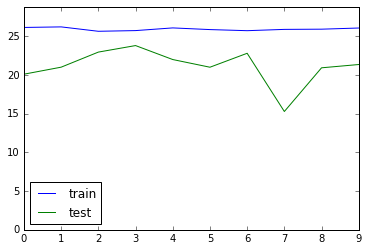

In [40]:
plt.plot(train,label='train')
plt.plot(test,label='test')

plt.ylim(0,np.max(train+test)*1.1)
plt.legend(loc='best')

In [7]:
from msmbuilder.example_datasets import AlanineDipeptide
trajs = AlanineDipeptide().get().trajectories

from msmbuilder.featurizer import AtomPairsFeaturizer
pairs = []
for i in range(trajs[0].n_atoms):
    for j in range(i):
        pairs.append((i,j))

atom_pairs = AtomPairsFeaturizer(pairs)
X_pairs = atom_pairs.fit_transform(trajs)

from msmbuilder.featurizer import DihedralFeaturizer
dih = DihedralFeaturizer(['phi', 'psi', 'omega', 'chi1', 'chi2', 'chi3', 'chi4'])
X_dih = dih.fit_transform(trajs)

from msmbuilder.featurizer import SuperposeFeaturizer
n_atoms = trajs[0].n_atoms
spf = SuperposeFeaturizer(range(n_atoms),trajs[0][0])
X_spf = spf.fit_transform(trajs)

from msmbuilder.featurizer import VonMisesFeaturizer
vmf = VonMisesFeaturizer()
X_vmf = vmf.fit_transform(trajs)

Xs = [X_pairs,X_dih,X_spf,X_vmf]
X_feat = [np.hstack([x[i] for x in Xs]) for i in range(len(trajs))]
X_feat[0].shape,X_pairs[0].shape,X_dih[0].shape,X_spf[0].shape,X_vmf[0].shape

((9999, 293), (9999, 231), (9999, 4), (9999, 22), (9999, 36))

In [122]:
#throws errors
#from msmbuilder.featurizer import VonMisesFeaturizer
#vmf = VonMisesFeaturizer(['phi', 'psi', 'omega', 'chi1', 'chi2', 'chi3', 'chi4'])
#X_vmf = vmf.fit_transform(trajs)

getting output of TICA: 100% (20/20) [#############################] eta 00:00 -

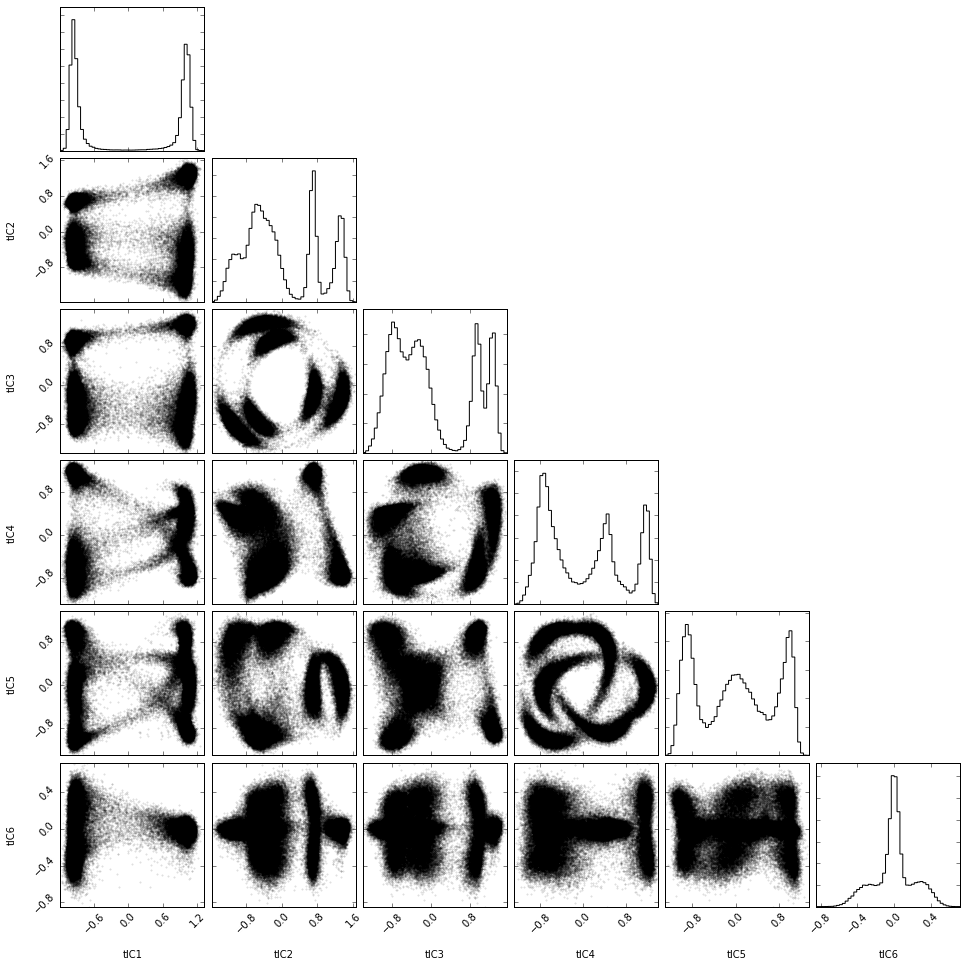

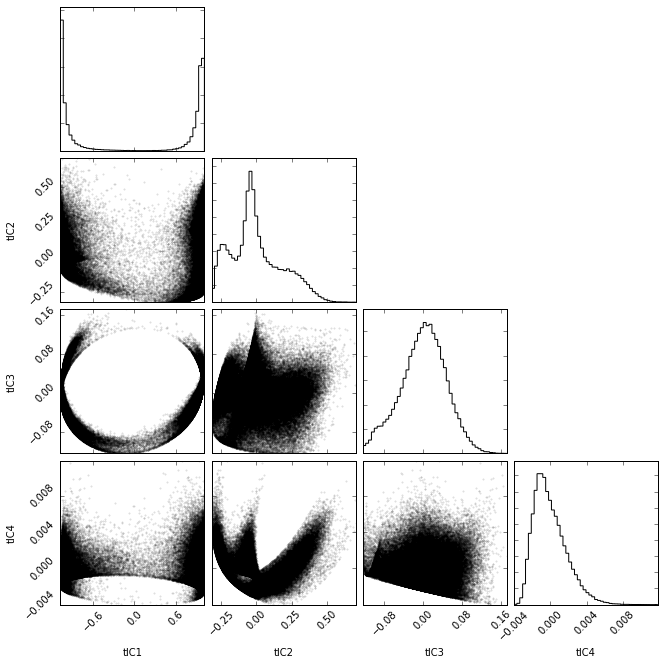

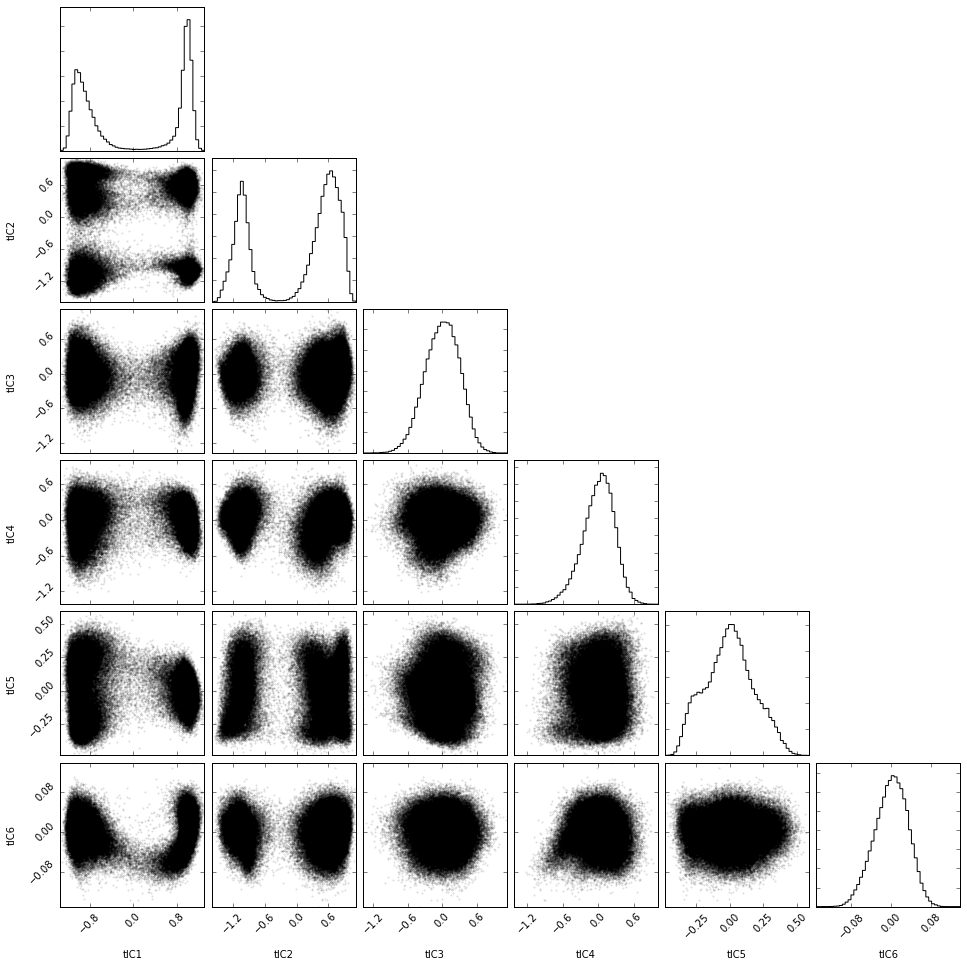

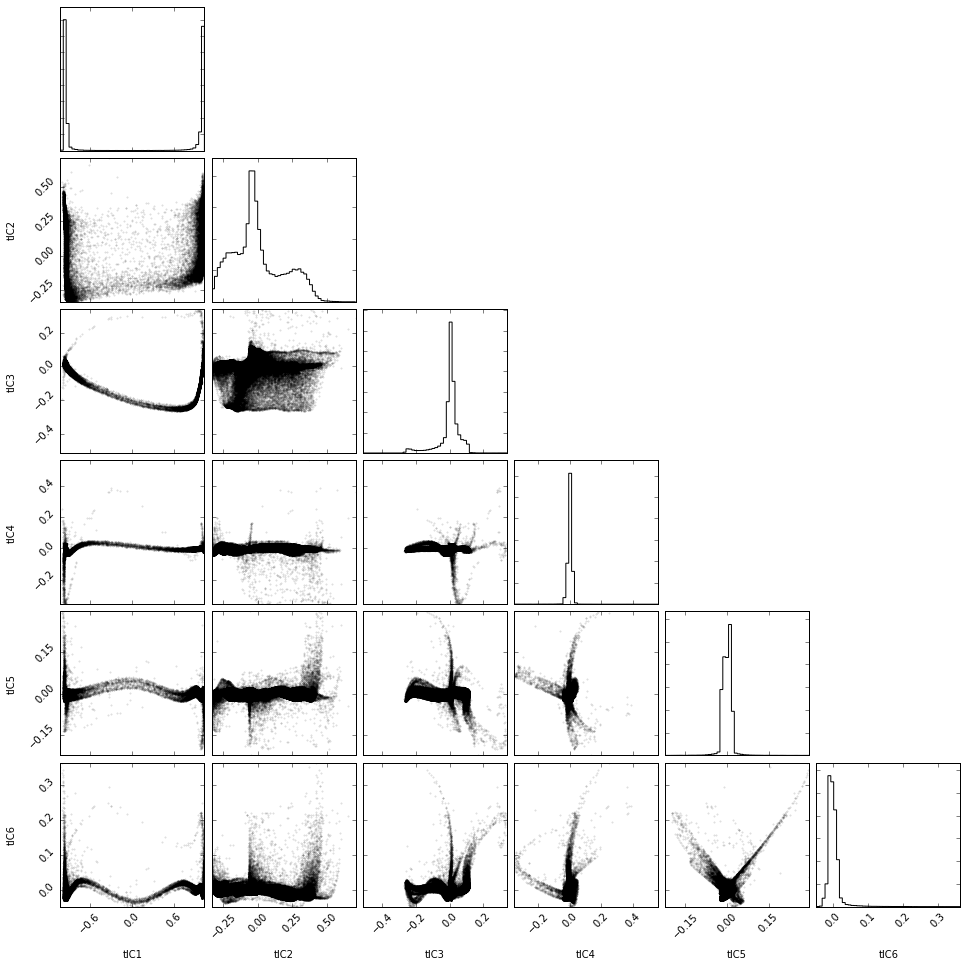

In [123]:
for feat in Xs:
    n_tics = min(6,feat[0].shape[1])
    tica.dimension
    tica = pyemma.coordinates.tica(feat,var_cutoff=1.0)
    X_feat_tica = tica.get_output()
    
    n_tics = min(6,X_feat_tica[0].shape[1])
    plt.figure()
    corner(np.vstack(X_feat_tica)[:,:n_tics],
           plot_contours=False,
           labels=['tIC{0}'.format(i+1) for i in range(n_tics)]
          )

In [127]:
tica = pyemma.coordinates.tica(X_feat,var_cutoff=0.999)
X_feat_tica = tica.get_output()

getting output of TICA: 100% (20/20) [#############################] eta 00:00 -

In [128]:
X_feat_tica[0].shape

(9999, 137)

In [129]:
kmeans = pyemma.coordinates.cluster_mini_batch_kmeans(X_feat_tica,k=100,max_iter=1000)
dtrajs = [dtraj.flatten() for dtraj in kmeans.get_output()]
msm = MarkovStateModel(lag_time=20,n_timescales=100)
msm.fit(dtrajs[:-1])
msm.score_,msm.score([dtrajs[-1]])

kmeans iterations:  20% ( 203/1000) [######                        ] eta 07:36 /07-05-16 23:22:06 pyemma.coordinates.clustering.kmeans.MiniBatchKmeansClustering[62] INFO     Cluster centers converged after 204 steps.
getting output of MiniBatchKmeansClustering: 100% (20/20) [########] eta 00:01 |MSM contains 1 strongly connected component above weight=0.05. Component 0 selected, with population 100.000000%
MSM contains 1 strongly connected component above weight=0.05. Component 0 selected, with population 100.000000%


(4.6335476695525424, 4.8102442232344504)

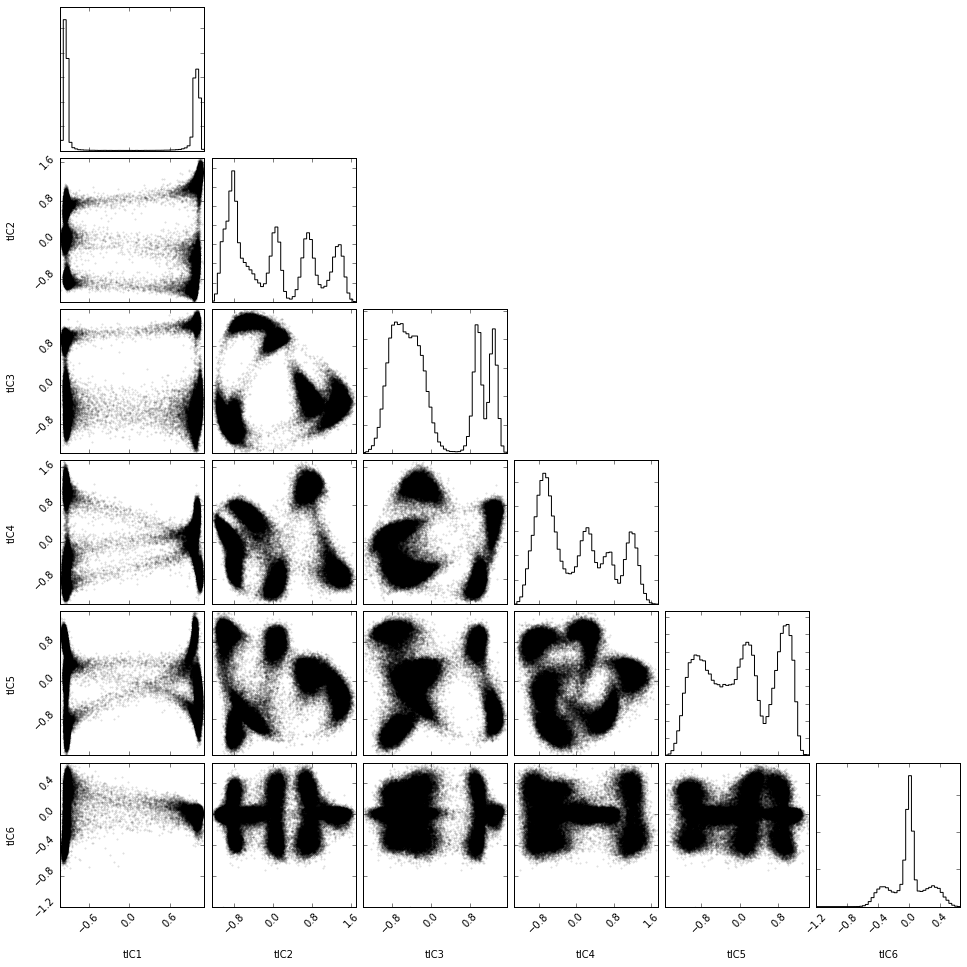

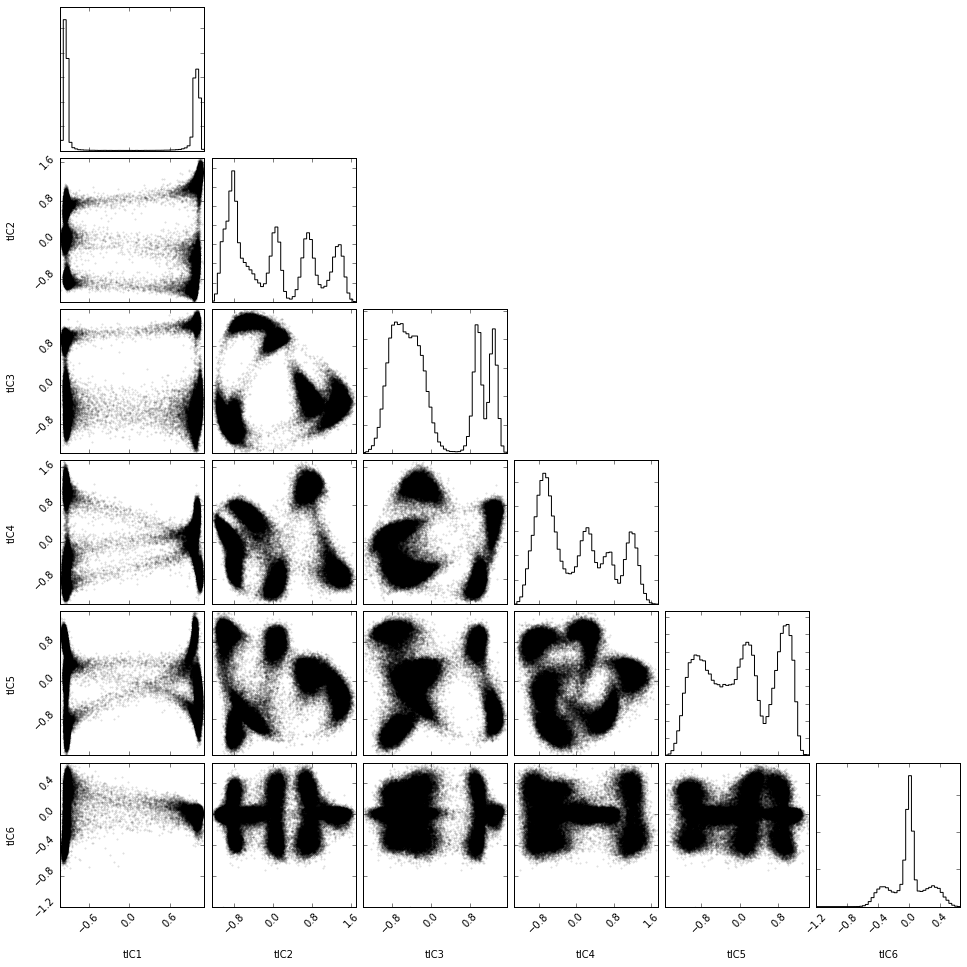

In [130]:
from triangle import corner
n_tics = min(6,X_feat_tica[0].shape[1])
corner(np.vstack(X_feat_tica)[:,:n_tics],
       plot_contours=False,
       labels=['tIC{0}'.format(i+1) for i in range(n_tics)]
      )

In [ ]:
def custom_corner

In [42]:
train_f,test_f = loo_cv(msm,dtrajs)

MSM contains 1 strongly connected component above weight=0.05. Component 0 selected, with population 100.000000%
MSM contains 1 strongly connected component above weight=0.05. Component 0 selected, with population 100.000000%
MSM contains 1 strongly connected component above weight=0.05. Component 0 selected, with population 100.000000%
MSM contains 1 strongly connected component above weight=0.05. Component 0 selected, with population 100.000000%
MSM contains 1 strongly connected component above weight=0.05. Component 0 selected, with population 100.000000%
MSM contains 1 strongly connected component above weight=0.05. Component 0 selected, with population 100.000000%
MSM contains 1 strongly connected component above weight=0.05. Component 0 selected, with population 100.000000%
MSM contains 1 strongly connected component above weight=0.05. Component 0 selected, with population 100.000000%
MSM contains 1 strongly connected component above weight=0.05. Component 0 selected, with popula

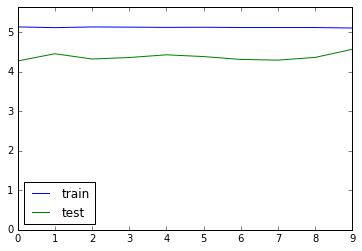

In [44]:
tica = tICA(n_components=20,lag_time=10)
train_t,test_t = loo_cv(tica,X_feat)
plt.plot(train_t,label='train')
plt.plot(test_t,label='test')
plt.ylim(0,np.max(train_t+test_t)*1.1)
plt.legend(loc='best')

In [44]:
tica = pyemma.coordinates.tica(X_feat)
np.sum(tica.eigenvalues**2)

calculate covariances: 100% (20/20) [##############################] eta 00:01 |

3.5946407083956111

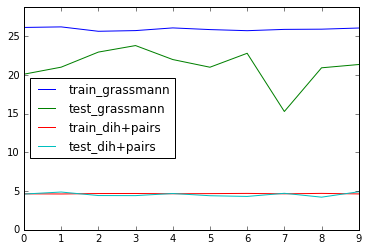

In [43]:
plt.plot(train,label='train_grassmann')
plt.plot(test,label='test_grassmann')

plt.plot(train_f,label='train_dih+pairs')
plt.plot(test_f,label='test_dih+pairs')

plt.ylim(0,np.max(train+test)*1.1)
plt.legend(loc='best')

calculate covariances: 100% (20/20) [##############################] eta 00:00 |

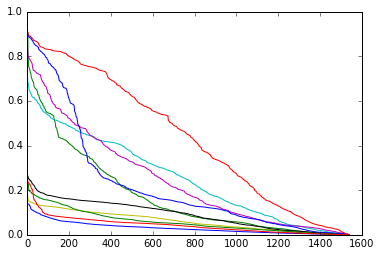

In [23]:
tica = pyemma.coordinates.tica(X)
for i in range(10):
    plt.plot(sorted(np.abs(tica.feature_TIC_correlation[:,i]))[::-1],c = tica.eigenvalues**2[i])

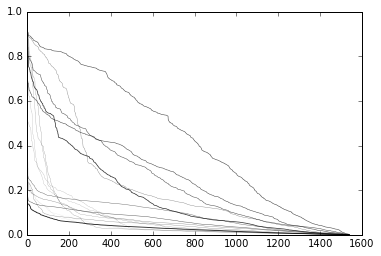

In [42]:
for i in range(tica.dimension()):
    weight = tica.eigenvalues[i]**2
    plt.plot(sorted(np.abs(tica.feature_TIC_correlation[:,i]))[::-1],alpha = weight, linewidth=weight**2, color='black')

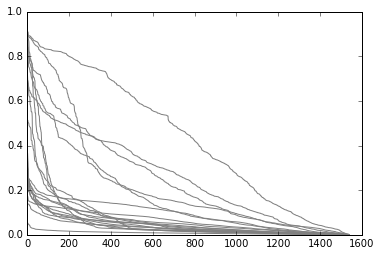

In [36]:
for i in range(tica.dimension()):
    plt.plot(sorted(np.abs(tica.feature_TIC_correlation[:,i]))[::-1], color='grey')

In [33]:
tica.dimension()

20

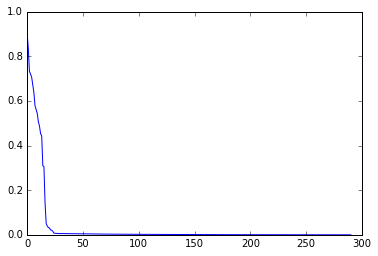

In [35]:
plt.plot(tica.eigenvalues**2)

(0, 1)

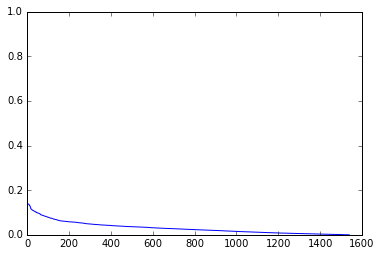

In [25]:
plt.plot(sorted(np.abs(tica.feature_TIC_correlation[:,0]))[::-1])
plt.ylim(0,1)

In [8]:
# all together now: what if we combine the atom-pairs and dihedrals with Grassmann features?
Xs0 = [X_feat,X]

X_tot = [np.hstack([x[i] for x in Xs0]) for i in range(len(trajs))]

In [9]:
X_tot[0].shape

(9999, 1833)

In [10]:
tica_tot = pyemma.coordinates.tica(X_tot)
X_tica_tot = tica_tot.get_output()

getting output of TICA: 100% (20/20) [#############################] eta 00:00 |

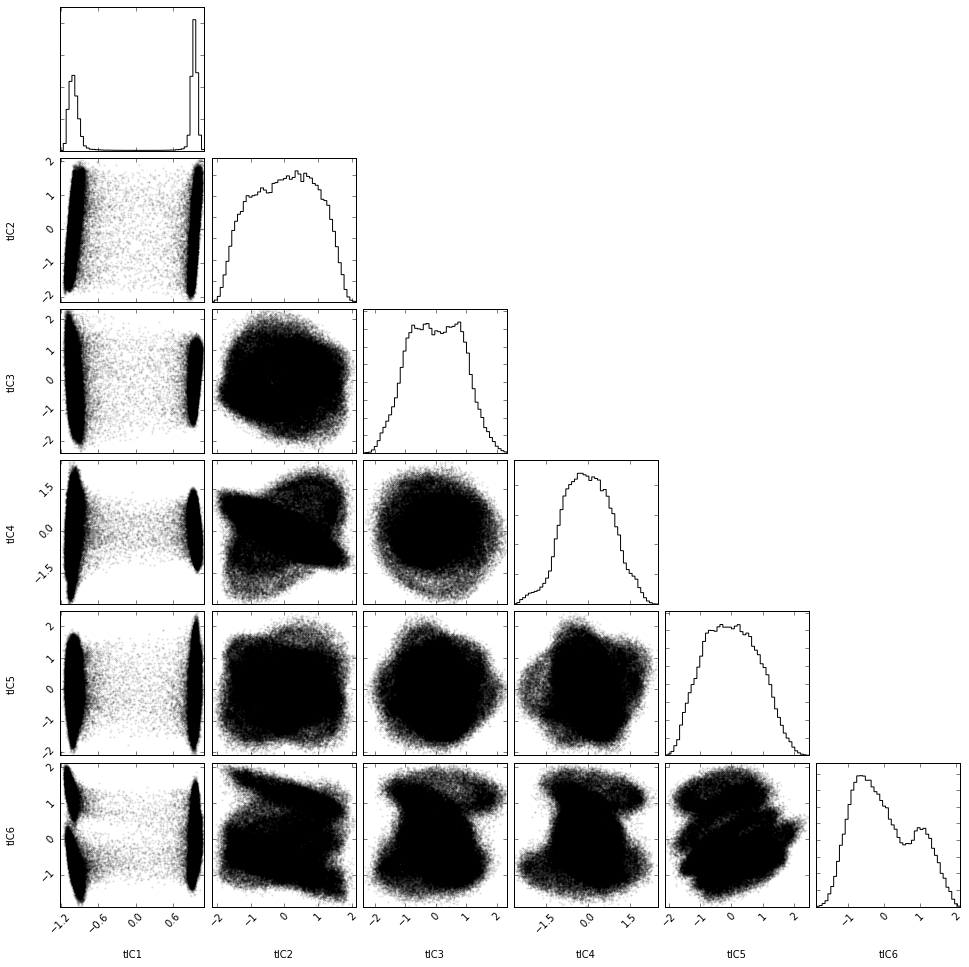

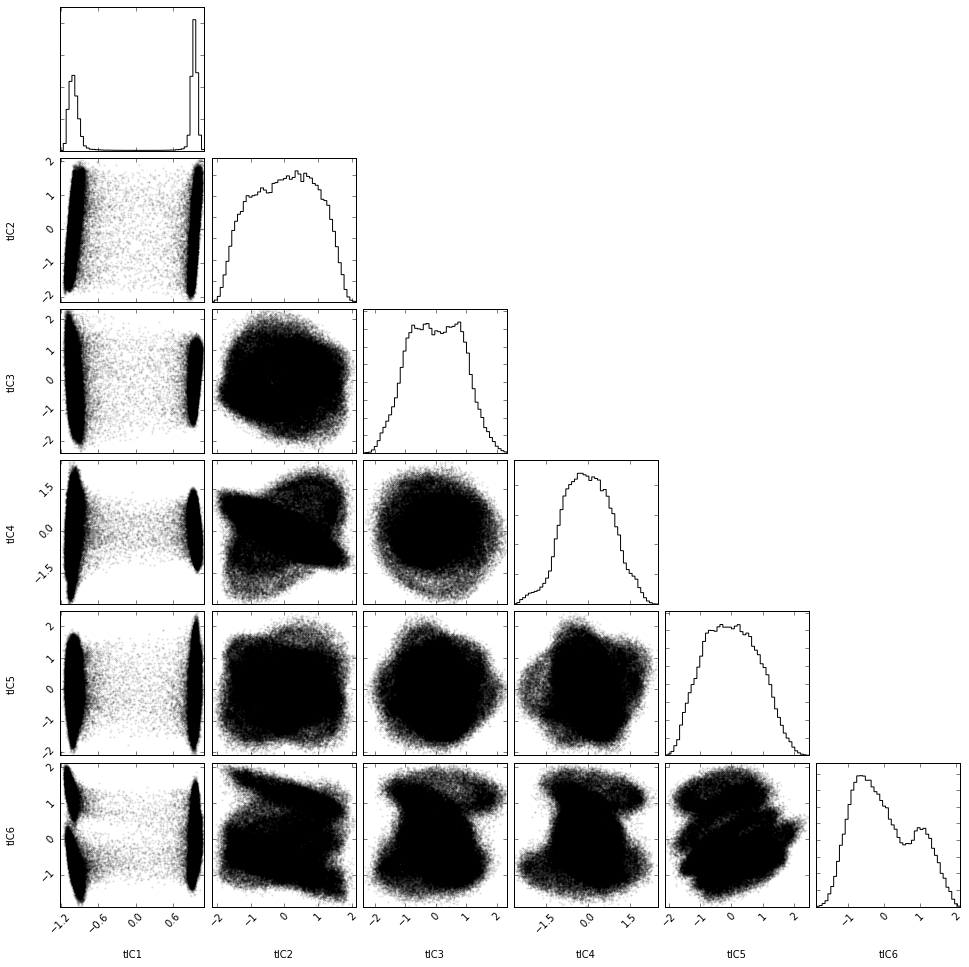

In [12]:
from triangle import corner
n_tics = min(6,X_tica_tot[0].shape[1])
corner(np.vstack(X_tica_tot)[:,:n_tics],
       plot_contours=False,
       labels=['tIC{0}'.format(i+1) for i in range(n_tics)]
      )

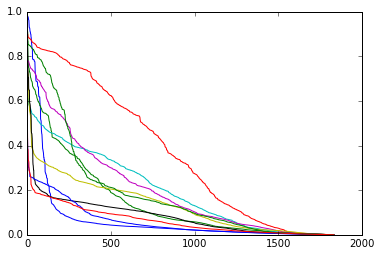

In [22]:
#for i in range(tica_tot.dimension()):
for i in range(10):
    plt.plot(sorted(np.abs(tica_tot.feature_TIC_correlation[:,i]))[::-1])

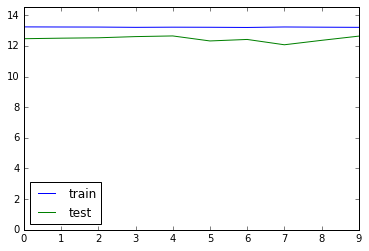

In [12]:
tica = tICA(n_components=20,lag_time=10,kinetic_mapping=False)
train_tot,test_tot = loo_cv(tica,X_tot)
plt.plot(train_tot,label='train')
plt.plot(test_tot,label='test')
plt.ylim(0,np.max(train_tot+test_tot)*1.1)
plt.legend(loc='best')

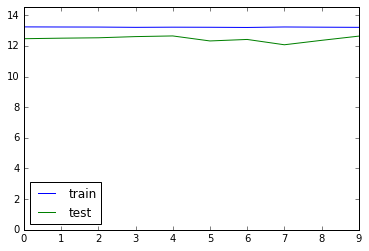

In [13]:
tica = tICA(n_components=20,lag_time=10,kinetic_mapping=True)
train_tot,test_tot = loo_cv(tica,X_tot)
plt.plot(train_tot,label='train')
plt.plot(test_tot,label='test')
plt.ylim(0,np.max(train_tot+test_tot)*1.1)
plt.legend(loc='best')